<a href="https://colab.research.google.com/github/kavyajeetbora/modern_geospatial_stack/blob/master/notebooks/accessibility_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q pandana
!pip install -q osmnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.2/107.2 kB 1.2 MB/s eta 0:00:00


- mapping the walk or drive time from each part of the city to its nearest amenity
- can most daily errands be completed on foot?

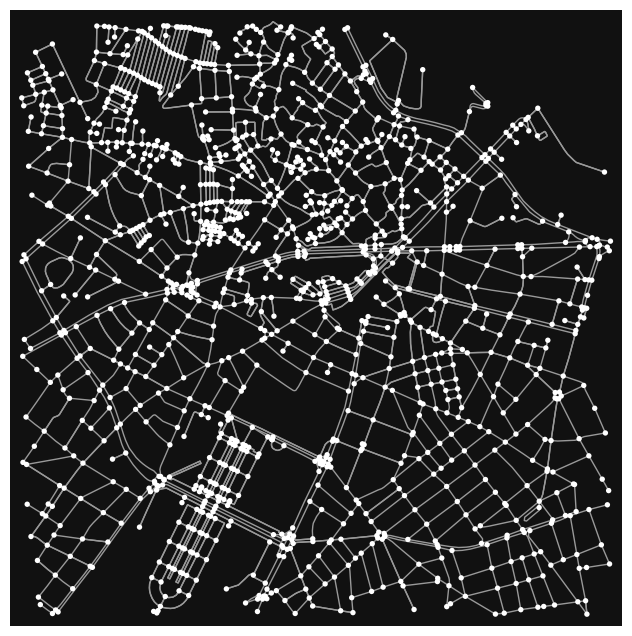

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [2]:
import osmnx as ox
G = ox.graph_from_address('Casablanca, Morocco')
ox.plot_graph(G)

In [19]:
nodes, edges = ox.convert.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True)
edges = edges.reset_index()

In [20]:
edges

,u,v,key,osmid,oneway,lanes,name,highway,maxspeed,reversed,length,geometry,junction,service,access,ref,tunnel
0,21426001,2401974410,0,422849180,True,3,Avenue des Forces Armées Royales شارع الجيش ال...,primary,60,False,20.407,"LINESTRING (-7.61726 33.59662, -7.61704 33.59662)",NaN,NaN,NaN,NaN,NaN
1,21426001,1848422066,0,422849181,True,2,Boulevard Moulay Hassan I,secondary,NaN,False,79.811,"LINESTRING (-7.61726 33.59662, -7.61734 33.596...",NaN,NaN,NaN,NaN,NaN
2,21542060,2138359227,0,422535897,True,3,Boulevard des Almohades,primary,NaN,False,18.136,"LINESTRING (-7.61395 33.59947, -7.61381 33.59936)",NaN,NaN,NaN,NaN,NaN
3,21542060,516618726,0,422535915,True,2,Boulevard Houphouët Boigny,secondary,NaN,False,88.886,"LINESTRING (-7.61395 33.59947, -7.61453 33.598...",NaN,NaN,NaN,NaN,NaN
4,21542309,25651891,0,214262735,True,2,Rue Omar Slaoui,residential,NaN,False,42.328,"LINESTRING (-7.61846 33.58891, -7.61874 33.58861)",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3194,11837449806,11828201147,0,1273792692,False,NaN,NaN,footway,NaN,True,4.711,"LINESTRING (-7.62424 33.58938, -7.62422 33.58942)",NaN,NaN,NaN,NaN,NaN
3195,11837449807,11828200809,0,666984280,False,NaN,NaN,footway,NaN,True,20.075,"LINESTRING (-7.62321 33.58895, -7.62341 33.58903)",NaN,NaN,NaN,NaN,NaN
3196,11837449807,11828200790,0,1273792679,False,NaN,NaN,footway,NaN,False,12.383,"LINESTRING (-7.62321 33.58895, -7.62327 33.58885)",NaN,NaN,NaN,NaN,NaN
3197,11837449807,11828200767,0,1273792679,False,NaN,NaN,footway,NaN,True,5.176,"LINESTRING (-7.62321 33.58895, -7.62319 33.58900)",NaN,NaN,NaN,NaN,NaN


In [23]:
import pandana as pdna

In [24]:
net= pdna.Network(nodes["x"], nodes["y"], edges["u"], edges["v"],edges[["length"]])

In [25]:
net

In [4]:
from pandana.loaders import osm

# define your selected amenities and bounding box
amenities = ['hospital', 'clinic', 'restaurant','cafe','school','bank','pharmacy','park']
bbox = [33.49422570442377,-7.709587097167969,33.64046399626814,-7.494117736816405]

# request them from the OpenStreetMap API (Overpass)
pois = osm.node_query(bbox[0], bbox[1], bbox[2], bbox[3],tags={'amenity': amenities})
pois = pois[pois['amenity'].isin(amenities)]

#List how many we downloaded
print(pois.amenity.value_counts())
pois[['amenity', 'name', 'lat', 'lon']].head()

amenity
bank          661
cafe          578
pharmacy      427
restaurant    388
school        117
clinic         32
hospital       11
Name: count, dtype: int64


,amenity,name,lat,lon
id,,,,
516618709,restaurant,La Bodega,33.595219,-7.611573
516618742,restaurant,La Sqala,33.602848,-7.619212
516618748,restaurant,Pizza Hut,33.592847,-7.597267
530761730,pharmacy,NaN,33.582109,-7.626557
566450810,restaurant,NaN,33.589686,-7.626574


## Third step: compute distances

- Pandana is built for speed.
- First, we’ll pass it a maximum search distance. distance is a variable that you can set yourself. eg. include a line 'distance = 1000' (this gives a maximum search distance of 1 kilometer)
- This allows a key step that speeds up future enquiries:
- Pandana will build a condensed representation of the network (implemented in C++), allowing rapid calculations within a defined radius of each node.
- We’ll build a table of distances to the nearest 5 points of interest from a couple of intersections
- This done, accessibility analyses for different selected amenities can be done in under a second. (Under the bonnet, two algorithms make this possible: contraction hierarchies and kd-trees.)

In [32]:
amenity = 'hospital'
pois_subset = pois[pois['amenity']==amenity]
print(pois_subset.shape)
pois_subset.sample(3)

(11, 217)


,lat,lon,amenity,building,name,addr:city,addr:housenumber,addr:street,drink:wine,phone,...,payment:cryptocurrencies,payment:electronic_purses,payment:google_pay,payment:mastercard_contactless,payment:unionpay,payment:uta,payment:v_pay,payment:notes,brewery,toilets:access
id,,,,,,,,,,,,,,,,,,,,,
9620697128,33.578588,-7.621404,hospital,NaN,MEDIMED Matériel Médical,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4057991325,33.558542,-7.573301,hospital,NaN,Hôpital Sidi Othmane,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9613551606,33.581587,-7.622023,hospital,NaN,Clinical Les Fleurs,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


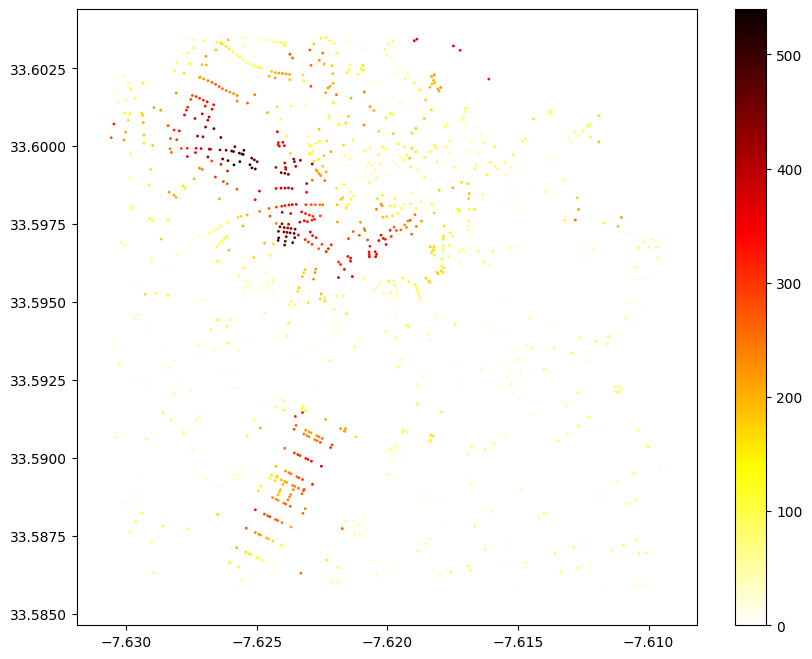

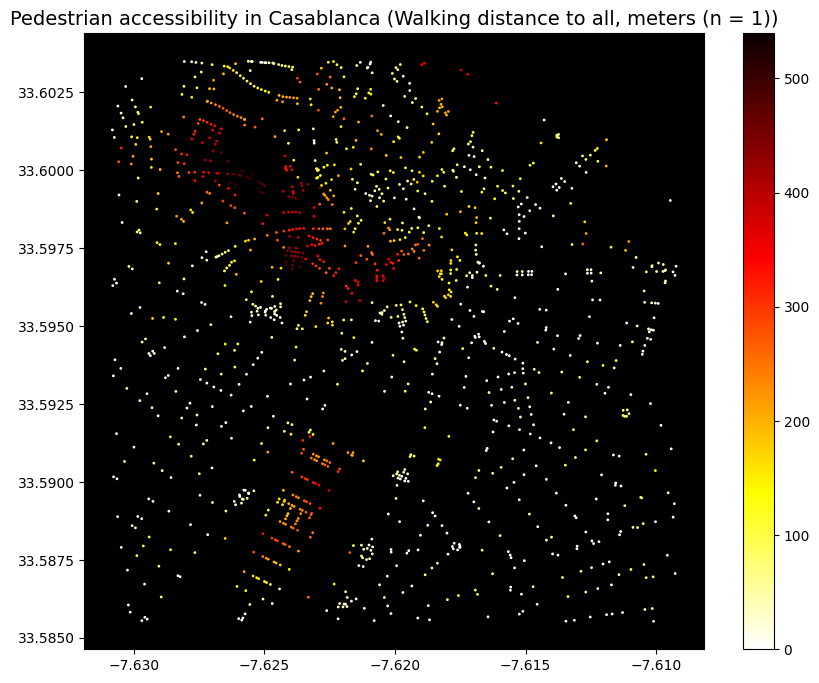

In [53]:
# initialize each amenity category with the locations (lon/lat coordinates)

distance=1000 ## in meters
num_pois = 10

amenity = 'all'
net.set_pois(category=amenity, maxdist = distance, maxitems=num_pois, x_col=pois['lon'], y_col=pois['lat'])
accessibility = net.nearest_pois(distance=distance, category=amenity, num_pois=num_pois)

def plot_nearest_amenity(accessibility,n):
    fig, ax = net.plot(accessibility[n], bbox=bbox);
    ax.set_facecolor('k');
    ax.set_title('Pedestrian accessibility in Casablanca (Walking distance to {}, meters (n = {}))'.format(amenity,n), fontsize=14);
    return fig

plot_nearest_amenity(accessibility,1)